# 13.6 Lab: Multiple Testing

## 13.6.1 Review of Hypothesis Tests

We begin by performing some one-sample $t$-tests using the `t.test()` function. 
First we create 100 variables, each consisting of 10 observations. 
The first 50 variables have mean 0.5 and variance 1, while the others have mean 0 and variance 1.

In [3]:
set.seed(6)
x <- matrix(rnorm(10 * 100), 10, 100)
x[, 1:50] <- x[, 1:50] + 0.5

The `t.test()` function can perform a one-sample or a two-sample $t$-test. 
By default, a one-sample test is performed. 
To begin, we test $H_0 : \mu_1 = 0$, the null hypothesis that the first variable has mean zero.

In [4]:
t.test(x[, 1], mu = 0)


	One Sample t-test

data:  x[, 1]
t = 2.0841, df = 9, p-value = 0.06682
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 -0.05171076  1.26242719
sample estimates:
mean of x 
0.6053582 


The $p$-value comes out to 0.067, which is not quite low enough to reject the null hypothesis at level $\alpha = 0.05$. 
In this case, $\mu_1 = 0.5$, so the null hypothesis is false. 
**Therefore, we have made a Type II error by failing to reject the null hypothesis when the null hypothesis is false.**

We now test $H_{0j} : \mu_j = 0$ for $j = 1,\ldots,100$. 
We compute the 100 $p$-values, and then construct a vector recording whether the $j$-th $p$-value is less than or equal to 0.05, in which case we reject $H_{0j}$, or greater than 0.05, in which case we do not reject $H_{0j}$, for $j = 1,\ldots,100$.

In [6]:
p_values <- rep(0, 100)
for (i in 1:100) {
    p_values[i] <- t.test(x[, i], mu = 0)$p.value
}
decision <- rep("Do not reject H0", 100)
decision[p_values <= 0.05] <- "Reject H0"

Since this is a simulated data set, we can create a $2\times 2$ table similar to Table 13.2.

In [7]:
table(
    decision,
    c(rep("H0 is False", 50), rep("H0 is True", 50))
)

                  
decision           H0 is False H0 is True
  Do not reject H0          40         47
  Reject H0                 10          3

Therefore, at level $\alpha = 0.05$, we reject just 10 of the 50 false null hypotheses, and we incorrectly reject 3 of the true null hypotheses. 
Using the notation from Section 13.3, we have $W = 40$, $U = 47$, $S = 10$, and $V = 3$. 
Note that the rows and columns of this table are reversed relative to Table 13.2. 
We have set $\alpha = 0.05$, which means that **we expect to reject around 5% of the true null hypotheses**. 
This is in line with the $2\times 2$ table above, which indicates that we rejected $V = 3$ of the 50 true null hypotheses.

In the simulation above, for the false null hypotheses, the ratio of the mean to the standard deviation was only $0.5/1 = 0.5$. 
This amounts to quite a weak signal, and it resulted in a high number of Type II errors. 
If we instead simulate data with a stronger signal, so that the ratio of the mean to the standard deviation for the false null hypotheses equals 1, then we make only 9 Type II errors.

In [8]:
x <- matrix(rnorm(10 * 100), 10, 100)
x[, 1:50] <- x[, 1:50] + 1
for (i in 1:100){
    p_values[i] <- t.test(x[, i], mu = 0)$p.value
}
decision <- rep("Do not reject H0", 100)
decision[p_values <= 0.05] <- "Reject H0"
table(
    decision,
    c(rep("H0 is False", 50), rep("H0 is True", 50))
)

                  
decision           H0 is False H0 is True
  Do not reject H0           9         49
  Reject H0                 41          1

## 13.6.2 The Family-Wise Error Rate

Recall from (13.5) that if the null hypothesis is true for each of $m$ independent hypothesis tests, then the FWER is equal to $1−(1−\alpha)^m$. 
We can use this expression to compute the FWER for $m = 1,\ldots,500$ and $\alpha = 0.05$, $0.01$, and $0.001$.

In [9]:
m <- 1:500
fwe1 <- 1 - (1 - 0.05)^m
fwe2 <- 1 - (1 - 0.01)^m
fwe3 <- 1 - (1 - 0.001)^m

We plot these three vectors in order to reproduce Figure 13.2. 
The red, blue, and green lines correspond to $\alpha = 0.05$, $0.01$, and $0.001$, respectively.

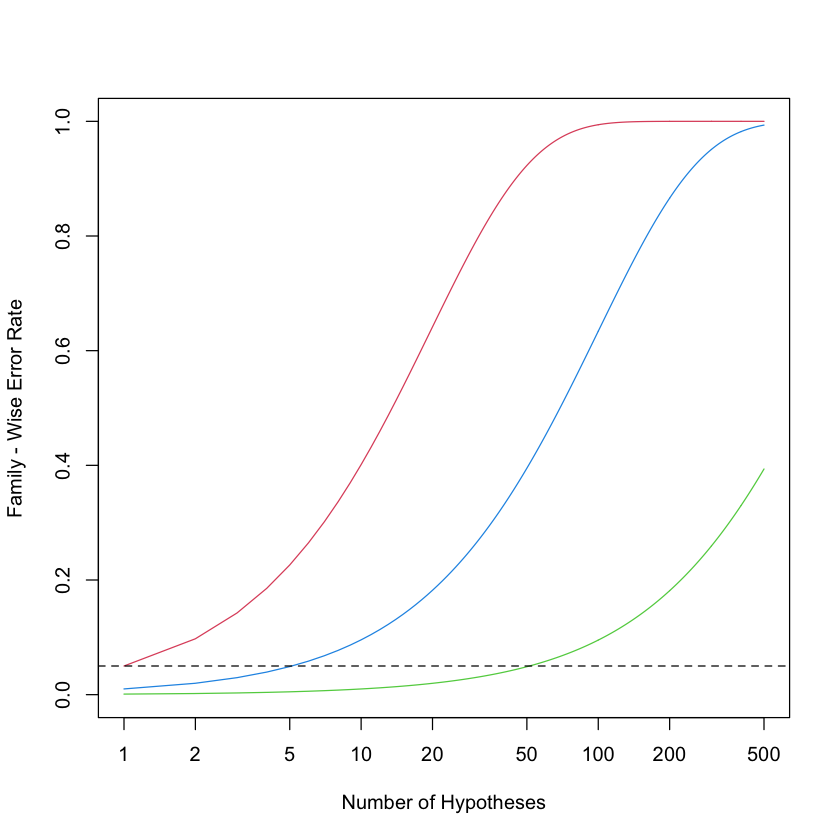

In [10]:
plot(m, fwe1,
     type = "l", log = "x",
     ylim = c(0, 1), col = 2,
     ylab = "Family - Wise Error Rate",
     xlab = "Number of Hypotheses")
lines(m, fwe2, col = 4)
lines(m, fwe3, col = 3)
abline(h = 0.05, lty = 2)

As discussed previously, even for moderate values of $m$ such as 50, the FWER exceeds 0.05 unless $\alpha$ is set to a very low value, such as 0.001. 
Of course, the problem with setting $\alpha$ to such a low value is that we are likely to make a number of Type II errors: in other words, our power is very low.

We now conduct a one-sample $t$-test for each of the first five managers in the `Fund` dataset, in order to test the null hypothesis that the $j$-th fund manager's mean return equals zero, $H_{0j} : μ_j = 0$.

In [11]:
library("ISLR2")
fund_mini <- Fund[, 1:5]
t.test(fund_mini[, 1], mu = 0)


	One Sample t-test

data:  fund_mini[, 1]
t = 2.8604, df = 49, p-value = 0.006202
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.8923397 5.1076603
sample estimates:
mean of x 
        3 


In [12]:
fund_pvalue <- rep(0, 5)
for (i in 1:5) {
    fund_pvalue[i] <- t.test(fund_mini[, i], mu = 0)$p.value
}
fund_pvalue

[1] 0.006202355 0.918271152 0.011600983 0.600539601 0.755781508

The $p$-values are low for Managers One and Three, and high for the other three managers. 
However, we cannot simply reject $H_{01}$ and $H_{03}$, since this would fail to account for the multiple testing that we have performed. 
Instead, we will conduct Bonferroni's method and Holm's method to control the FWER.

To do this, we use the `p.adjust()` function. 
Given the $p$-values, the function outputs *adjusted $p$-values*, which can be thought of as a new set of $p$-values that have been corrected for multiple testing. 
If the adjusted $p$-value for a given hypothesis is less than or equal to $\alpha$, then that hypothesis can be rejected while maintaining a FWER of no more than $\alpha$. 
In other words, the adjusted $p$-values resulting from the `p.adjust()` function can simply be compared to the desired FWER in order to determine whether or not to reject each hypothesis.

For example, in the case of Bonferroni's method, the raw $p$-values are multiplied by the total number of hypotheses, $m$, in order to obtain the adjusted $p$-values. 
(However, adjusted $p$-values are not allowed to exceed 1.)

In [13]:
p.adjust(fund_pvalue, method = "bonferroni")

[1] 0.03101178 1.00000000 0.05800491 1.00000000 1.00000000

In [14]:
pmin(fund_pvalue * 5, 1)

[1] 0.03101178 1.00000000 0.05800491 1.00000000 1.00000000

Therefore, using Bonferroni's method, we are able to reject the null hypothesis only for Manager One while controlling the FWER at 0.05.

By contrast, using Holm's method, the adjusted $p$-values indicate that we can reject the null hypotheses for Managers One and Three at a FWER of 0.05.

In [15]:
p.adjust(fund_pvalue, method = "holm")

[1] 0.03101178 1.00000000 0.04640393 1.00000000 1.00000000

As discussed previously, Manager One seems to perform particularly well, whereas Manager Two has poor performance.

In [17]:
print(apply(fund_mini, 2, mean))

Manager1 Manager2 Manager3 Manager4 Manager5 
     3.0     -0.1      2.8      0.5      0.3 


Is there evidence of a meaningful difference in performance between these two managers? 
Performing a paired $t$-test using the `t.test()` function results in a $p$-value of 0.038, suggesting a statistically significant difference.

In [18]:
t.test(fund_mini[, 1], fund_mini[, 2], paired = T)


	Paired t-test

data:  fund_mini[, 1] and fund_mini[, 2]
t = 2.128, df = 49, p-value = 0.03839
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 0.1725378 6.0274622
sample estimates:
mean of the differences 
                    3.1 


However, we decided to perform this test only after examining the data and noting that Managers One and Two had the highest and lowest mean performances. 
In a sense, this means that we have implicitly performed $\text{choose}(5, 2) = 5(5 − 1)/2 = 10$ hypothesis tests, rather than just one, as discussed in Section 13.3.2. 
Hence, we use the `TukeyHSD()` function to apply Tukey's method in order to adjust for multiple testing.
This function takes as input the output of an ANOVA regression model, which is essentially just a linear regression in which all of the predictors are qualitative. 
In this case, the response consists of the monthly excess returns achieved by each manager, and the predictor indicates the manager to which each return corresponds.

In [20]:
returns <- as.vector(as.matrix(fund_mini))
manager <- rep(c("1", "2", "3", "4", "5"), rep(50, 5))
a1 <- aov(returns ~ manager)
TukeyHSD(x = a1)

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = returns ~ manager)

$manager
    diff        lwr       upr     p adj
2-1 -3.1 -6.9865435 0.7865435 0.1861585
3-1 -0.2 -4.0865435 3.6865435 0.9999095
4-1 -2.5 -6.3865435 1.3865435 0.3948292
5-1 -2.7 -6.5865435 1.1865435 0.3151702
3-2  2.9 -0.9865435 6.7865435 0.2452611
4-2  0.6 -3.2865435 4.4865435 0.9932010
5-2  0.4 -3.4865435 4.2865435 0.9985924
4-3 -2.3 -6.1865435 1.5865435 0.4819994
5-3 -2.5 -6.3865435 1.3865435 0.3948292
5-4 -0.2 -4.0865435 3.6865435 0.9999095


The `TukeyHSD()` function provides confidence intervals for the difference between each pair of managers (`lwr` and `upr`), as well as a $p$-value. 
All of these quantities have been adjusted for multiple testing. 
Notice that the $p$-value for the difference between Managers One and Two has increased from 0.038 to 0.186, so there is no longer clear evidence of a difference between the managers' performances. 
We can plot the confidence intervals for the pairwise comparisons using the `plot()` function.

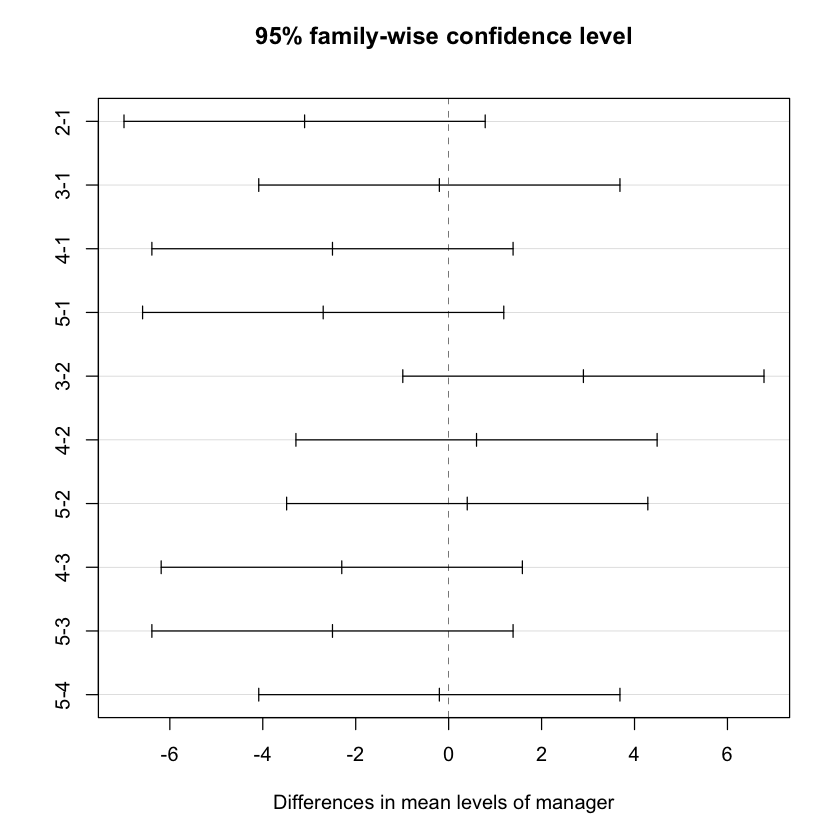

In [21]:
plot(TukeyHSD(x = a1))

## 13.6.3 The False Discovery Rate

Now we perform hypothesis tests for all 2000 fund managers in the `Fund` dataset. 
We perform a one-sample $t$-test of $H_{0j} : \mu_j = 0$, which states that the $j$-th fund manager's mean return is zero.

In [22]:
fund_pvalues <- rep(0, 2000)
for (i in 1:2000) {
    fund_pvalues[i] <- t.test(Fund[, i], mu = 0)$p.value
}

There are far too many managers to consider trying to control the FWER. 
Instead, we focus on controlling the FDR: that is, the expected fraction of rejected null hypotheses that are actually false positives. 
The `p.adjust()` function can be used to carry out the Benjamini-Hochberg procedure.

In [24]:
q_values_BH <- p.adjust(fund_pvalues, method = "BH")
q_values_BH[1:10]

[1] 0.08988921 0.99149100 0.12211561 0.92342997 0.95603587 0.07513802
 [7] 0.07670150 0.07513802 0.07513802 0.07513802

The $q$-values output by the Benjamini-Hochberg procedure can be interpreted as the smallest FDR threshold at which we would reject a particular null hypothesis. 
For instance, a $q$-value of 0.1 indicates that we can reject the corresponding null hypothesis at an FDR of 10% or greater, but that we cannot reject the null hypothesis at an FDR below 10%.

If we control the FDR at 10%, then for how many of the fund managers can we reject $H_{0j} : \mu_j = 0$?

In [25]:
sum(q_values_BH <= 0.1)

[1] 146

We find that 146 of the 2000 fund managers have a $q$-value below 0.1; therefore, we are able to conclude that 146 of the fund managers beat the market at an FDR of 10%. 
Only about 15 (10% of 146) of these fund managers are likely to be false discoveries. 
By contrast, if we had instead used Bonferroni's method to control the FWER at level $\alpha = 0.1$, then we would have failed to reject any null hypotheses!

In [26]:
sum(fund_pvalues <= (0.1 / 2000))

[1] 0

Figure 13.6 displays the ordered $p$-values, $p_{(1)} \leq p_{(2)} \leq \cdots \leq p_{(2000)}$, for the `Fund` dataset, as well as the threshold for rejection by the Benjamini-Hochberg procedure. 
Recall that the Benjamini-Hochberg procedure searches for the largest $p$-value such that $p_{(j)} < q_j/m$, and rejects all hypotheses for which the $p$-value is less than or equal to $p_{(j)}$. 
In the code below, we implement the Benjamini-Hochberg procedure ourselves, in order to illustrate how it works. 
We first order the $p$-values. 
We then identify all $p$-values that satisfy $p_{(j)} < q_j/m$ (`wh_ps`). 
Finally, `wh` indexes all $p$-values that are less than or equal to the largest p-value in `wh_ps`. 
Therefore, `wh` indexes the $p$-values rejected by the Benjamini-Hochberg procedure.

In [29]:
ps <- sort(fund_pvalues)
m <- length(fund_pvalues)
q <- 0.1
wh_ps <- which(ps < (q * (1:m) / m))
if (length(wh_ps) > 0) {
    wh <- 1:max(wh_ps)
} else {
    wh <- numeric(0)
}

We now reproduce the middle panel of Figure 13.6.

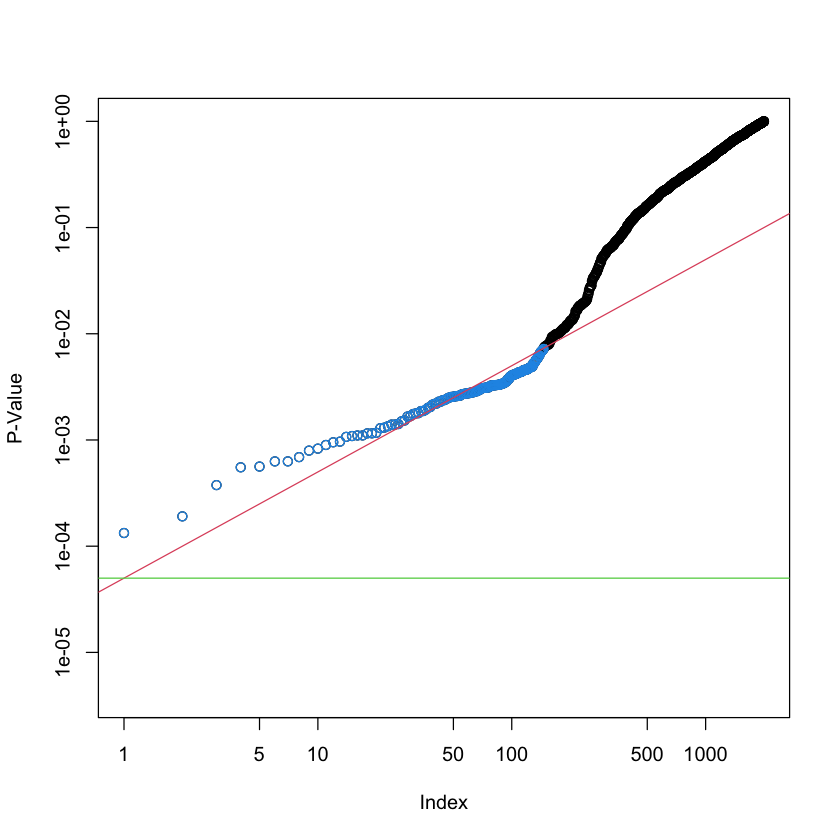

In [30]:
plot(ps, log = "xy", ylim = c(4e-6, 1), ylab = "P-Value", xlab = "Index", main = "")
points(wh, ps[wh], col = 4)
abline(a = 0, b = (q / m), col = 2, untf = TRUE)
abline(h = 0.1 / 2000, col = 3)

## 13.6.4 A Re-Sampling Approach

Here, we implement the re-sampling approach to hypothesis testing using the `Khan` dataset, which we investigated in Section 13.5. 
First, we merge the training and testing data, which results in observations on 83 patients for 2308 genes.

In [31]:
attach(Khan)
x <- rbind(xtrain, xtest)
y <- c(as.numeric(ytrain), as.numeric(ytest))
dim(x)

[1]   83 2308

In [32]:
table(y)

y
 1  2  3  4 
11 29 18 25 

There are four classes of cancer. 
For each gene, we compare the mean expression in the second class (rhabdomyosarcoma) to the mean expression in the fourth class (Burkitt's lymphoma). 
Performing a standard two-sample $t$-test on the 11th gene produces a test-statistic of −2.09 and an associated $p$-value of 0.0412, suggesting modest evidence of a difference in mean expression levels between the two cancer types.

In [34]:
x <- as.matrix(x)
x1 <- x[which(y == 2), ]
x2 <- x[which(y == 4), ]
n1 <- nrow(x1)
n2 <- nrow(x2)
t_out <- t.test(x1[, 11], x2[, 11], var.equal = T)
tt <- t_out$statistic

In [35]:
tt

t 
-2.093633

In [36]:
t_out$p.value

[1] 0.04118644

However, this $p$-value relies on the assumption that under the null hypothesis of no difference between the two groups, the test statistic follows a $t$-distribution with $29 + 25 − 2 = 52$ degrees of freedom. 
Instead of using this theoretical null distribution, we can randomly split the 54 patients into two groups of 29 and 25, and compute a new test statistic. 
Under the null hypothesis of no difference between the groups, this new test statistic should have the same distribution as our original one. 
Repeating this process 10000 times allows us to approximate the null distribution of the test statistic. 
We compute the fraction of the time that our observed test statistic exceeds the test statistics obtained via re-sampling.

In [39]:
set.seed(1)
B <- 10000
tbs <- rep(NA, B)
for (b in 1:B) {
    dat <- sample(c(x1[, 11], x2[, 11]))
    tbs[b] <- t.test(dat[1:n1], dat[(n1+1):n1+n2], var.equal = T)$statistic
}
mean(abs(tbs) >= abs(tt))

[1] 0.0363

This fraction, 0.0416, is our re-sampling-based $p$-value. 
It is almost identical to the $p$-value of 0.0412 obtained using the theoretical null distribution.
We can plot a histogram of the re-sampling-based test statistics in order to reproduce Figure 13.7.

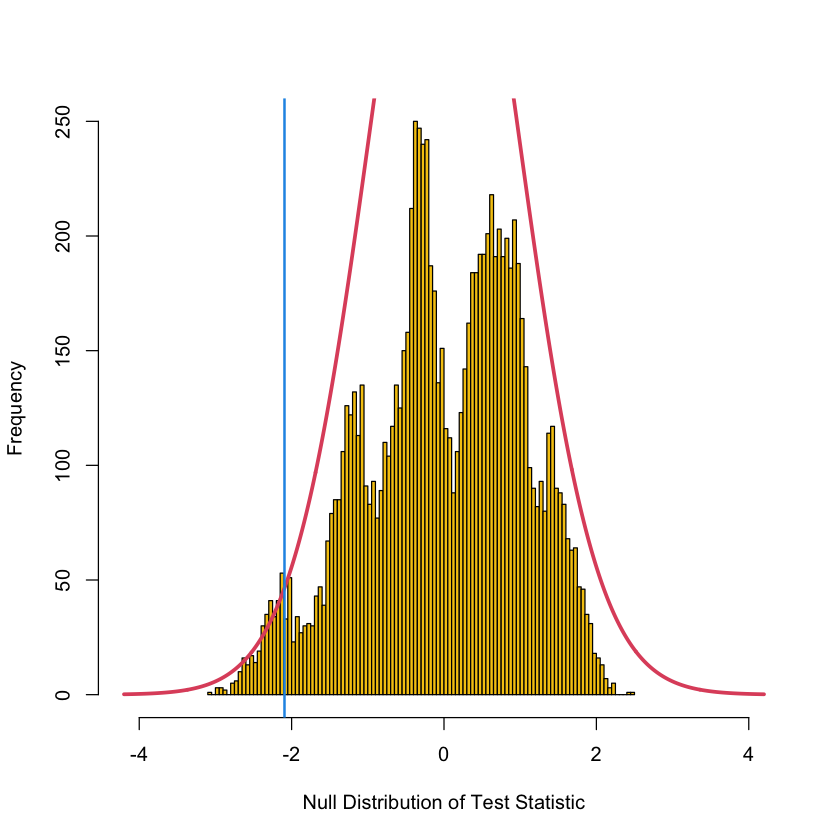

In [41]:
hist(tbs, breaks = 100,
     xlim = c(-4.2, 4.2), main = "",
     xlab = "Null Distribution of Test Statistic",
     col = 7)
lines(
    seq(-4.2, 4.2, len = 1000),
    dt(seq(-4.2, 4.2, len = 1000), df = (n1 + n2 - 2)) * 1000,
    col = 2, lwd = 3)
abline(v = tt, col = 4, lwd = 2)
text(tt + 0.5, 350, paste("T = ", round(tt, 4), sep = ""), col = 4)

The re-sampling-based null distribution is almost identical to the theoretical null distribution, which is displayed in red.

Finally, we implement the plug-in re-sampling FDR approach outlined in Algorithm 13.4. 
Depending on the speed of your computer, calculating the FDR for all 2308 genes in the `Khan` dataset may take a while. 
Hence, we will illustrate the approach on a random subset of 100 genes. 
For each gene, we first compute the observed test statistic, and then produce 10000 re-sampled test statistics. 
This may take a few minutes to run. 
If you are in a rush, then you could set `B` equal to a smaller value (e.g. `B = 500`).

In [42]:
m <- 100
B <- 100
set.seed (1)
index <- sample(ncol(x1), m)
Ts <- rep(NA, m)
Ts.star <- matrix(NA, ncol = m, nrow = B) 
for (j in 1:m) {
    k <- index[j]
    Ts[j] <- t.test(x1[, k], x2[, k], var.equal = TRUE )$statistic
    for (b in 1:B) {
        dat <- sample(c(x1[, k], x2[, k]))
        Ts.star[b, j] <- t.test(dat[1:n1], dat[(n1 + 1):(n1 + n2)], var.equal = TRUE )$statistic
    }
}

Next, we compute the number of rejected null hypotheses $R$, the estimated number of false positives $\hat{V}$, and the estimated FDR, for a range of threshold values $c$ in Algorithm 13.4.
The threshold values are chosen using the absolute values of the test statistics from the 100 genes.

In [43]:
cs <- sort(abs(Ts))
FDRs <- Rs <- Vs <- rep(NA, m)
for (j in 1:m) {
    R <- sum(abs(Ts) >= cs[j])
    V <- sum(abs(Ts.star) >= cs[j]) / B 
    Rs[j] <- R
    Vs[j] <- V
    FDRs[j]<-V/R
}

Now, for any given FDR, we can find the genes that will be rejected. 
For example, with the FDR controlled at 0.1, we reject 15 of the 100 null hypotheses. 
On average, we would expect about one or two of these genes (i.e. 10% of 15) to be false discoveries. 
At an FDR of 0.2, we can reject the null hypothesis for 28 genes, of which we expect around six to be false discoveries. The variable index is needed here since we restricted our analysis to just 100 randomly-selected genes.

In [44]:
max(Rs[FDRs <= 0.1])

[1] 15

In [45]:
sort(index[abs(Ts) >= min(cs[FDRs < 0.1])])

[1]   29  465  501  554  573  729  733 1301 1317 1640 1646 1706 1799 1942 2159

In [46]:
max(Rs[FDRs <= 0.2])

[1] 28

In [47]:
sort(index[abs(Ts) >= min(cs[FDRs < 0.2])])

[1]   29   40  287  361  369  465  501  554  573  679  729  733  990 1069 1073
[16] 1301 1317 1414 1639 1640 1646 1706 1799 1826 1942 1974 2087 2159

The next line generates Figure 13.11, which is similar to Figure 13.9, except that it is based on only a subset of the genes.

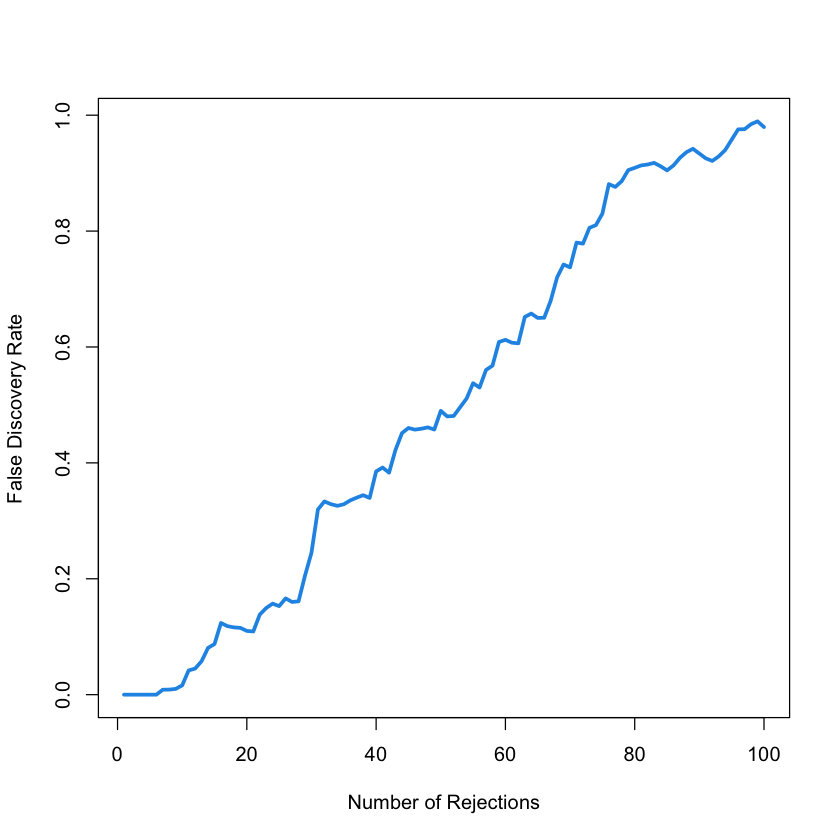

In [48]:
plot(Rs, FDRs, xlab = "Number of Rejections", type = "l", ylab = "False Discovery Rate", col = 4, lwd = 3)

As noted in the chapter, much more efficient implementations of the re-sampling approach to FDR calculation are available, using e.g. the `samr` package in `R`.